In [5]:
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import pandas as pd

Filter input cijfer

In [83]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

num = 2

x = list()

for i in range(train_labels.shape[0]):
    if train_labels[i] == num:
        x.append(i)

train_images = train_images[x]
train_labels = train_labels[x]

In [84]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Makes a model and imports an array with random values

In [86]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

generator = make_generator_model()

noise = tf.random.normal([1, 100])

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_discriminator_model()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    #display.clear_output(wait=True)
    #generate_and_save_images(generator, epoch + 1, seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  checkpoint.save(file_prefix = checkpoint_prefix)
  #display.clear_output(wait=True)
  #generate_and_save_images(generator,epochs,seed)

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [87]:
train(train_dataset, EPOCHS)

Time for epoch 1 is 4.153169393539429 sec
Time for epoch 2 is 2.3132259845733643 sec
Time for epoch 3 is 2.3767948150634766 sec
Time for epoch 4 is 2.3841028213500977 sec
Time for epoch 5 is 2.398827314376831 sec
Time for epoch 6 is 2.475964307785034 sec
Time for epoch 7 is 2.5867607593536377 sec
Time for epoch 8 is 2.704646110534668 sec
Time for epoch 9 is 2.7049973011016846 sec
Time for epoch 10 is 2.705477714538574 sec
Time for epoch 11 is 2.6964356899261475 sec
Time for epoch 12 is 2.697807788848877 sec
Time for epoch 13 is 2.6958961486816406 sec
Time for epoch 14 is 2.698279619216919 sec
Time for epoch 15 is 2.697126626968384 sec
Time for epoch 16 is 2.6942765712738037 sec
Time for epoch 17 is 2.6941967010498047 sec
Time for epoch 18 is 2.6961801052093506 sec
Time for epoch 19 is 2.6965484619140625 sec
Time for epoch 20 is 2.693629741668701 sec
Time for epoch 21 is 2.6950080394744873 sec
Time for epoch 22 is 2.6947109699249268 sec
Time for epoch 23 is 2.695668935775757 sec
Time fo

In [13]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

CODE from model.ipynb:
ik heb hier de mijn code geplaatst om de afbeelding te kunnen catorizen

In [32]:
digits_train = pd.read_csv("data/train.csv")


#input data for awnsering opdracht
digits_test = pd.read_csv("data/test.csv")
test_data_in = digits_test.to_numpy()
test_data = np.reshape(test_data_in, (test_data_in.shape[0], 28, 28))
test_data = np.expand_dims(test_data, axis=3)

#split traindata for train and validation data and labels
msk = np.random.rand(len(digits_train)) < 0.8 # maak een random mask voor het splitsen tussen train data en verification data.
#msk is een bool list die random zijn.
train = digits_train[msk]
val = digits_train[~msk]

#to numpy
train_data_in = train.to_numpy()
val_data_in = val.to_numpy()


# get labels
train_labels = train_data_in[:, 0]  # get first colom from the training data
val_labels = val_data_in[:, 0]  # get first colom from the training data
train_data_without_label = train_data_in[:, 1:]  # remove first colom (labels) from the training data
val_data_without_label = val_data_in[:, 1:]  # remove first colom (labels) from the training data


# make a 3d array (size, 28, 28)
train_data = np.reshape(train_data_without_label, (train_data_without_label.shape[0], 28, 28))
val_data = np.reshape(val_data_without_label, (val_data_without_label.shape[0], 28, 28))

# make proper dimensions
train_data = np.expand_dims(train_data, axis=3)
#test_data = np.expand_dims(test_data, axis=3)
val_data = np.expand_dims(val_data, axis=3)

# variables for model
num_filters = 2
filter_size = (3, 3)
pool_size = (2, 2) # Deze pool_size is klein omdat de dataset klein (28x28) is. wanneer deze hoger is zullen er meer fouten in komen. (bijvoorbeeld bij een open 0 en een 6)

model = Sequential([])

model.add(Conv2D(10, (3, 3), padding='same', activation='relu', input_shape=train_data.shape[1:]))
model.add(Conv2D(20, (3, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=pool_size))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

h = model.fit(train_data, train_labels, epochs=16, validation_data=(val_data, val_labels))

test_loss, test_acc = model.evaluate(train_data,  train_labels, verbose=2)
print("accuracy = {}".format(test_acc))

Epoch 1/16
1051/1051 [==============================] - 5s 4ms/step - loss: 0.8059 - accuracy: 0.9170 - val_loss: 0.1246 - val_accuracy: 0.9653
Epoch 2/16
1051/1051 [==============================] - 4s 4ms/step - loss: 0.0865 - accuracy: 0.9745 - val_loss: 0.1061 - val_accuracy: 0.9690
Epoch 3/16
1051/1051 [==============================] - 4s 4ms/step - loss: 0.0590 - accuracy: 0.9822 - val_loss: 0.0843 - val_accuracy: 0.9765
Epoch 4/16
1051/1051 [==============================] - 4s 4ms/step - loss: 0.0490 - accuracy: 0.9847 - val_loss: 0.1301 - val_accuracy: 0.9686
Epoch 5/16
1051/1051 [==============================] - 4s 4ms/step - loss: 0.0432 - accuracy: 0.9858 - val_loss: 0.1068 - val_accuracy: 0.9735
Epoch 6/16
1051/1051 [==============================] - 4s 4ms/step - loss: 0.0397 - accuracy: 0.9879 - val_loss: 0.0948 - val_accuracy: 0.9781
Epoch 7/16
1051/1051 [==============================] - 4s 4ms/step - loss: 0.0340 - accuracy: 0.9891 - val_loss: 0.1106 - val_accuracy:

---

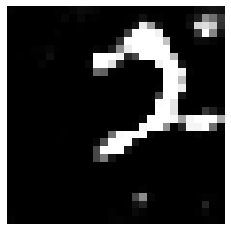

working: (1, 28, 28, 1), not (1, 28, 28, 1)
[[7.9931997e-21 1.9564412e-23 1.0000000e+00 0.0000000e+00 4.4593285e-24
  1.0776388e-29 2.5096827e-34 5.0330237e-21 1.8323470e-24 1.3294203e-25]]
image contains: 2
confident


In [131]:
s= tf.random.normal([1, noise_dim])
p = generator(s)
plt.imshow(p[0, :, :, 0], cmap='gray' )
plt.axis("off")
plt.show()


# x = np.expand_dims(p, axis=0)
x = np.expand_dims(test_data[10], axis=0)
print("working: {}, not {}".format(x.shape, p.shape))
prediction = model.predict(p* 127.5 + 127.5)
print(prediction)
n = np.argmax(prediction)
print("image contains: {}".format(n))
if prediction[0][n] >= 1:
    print("confident")

In [31]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [32]:
display_image(EPOCHS)

FileNotFoundError: [Errno 2] No such file or directory: 'image_at_epoch_0050.png'

In [193]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)